In [1]:
import os
from importlib.resources import files

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dim = 2
num_traj = 3  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory

train_x = np.empty((0, 4))
train_y = np.empty((0, 2))

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    data[-1,2:4] = np.zeros(2)
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    train_x = np.append(train_x, data[idx,:4], axis=0)
    train_y = np.append(train_y, data[idx,-2:], axis=0)

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [4]:
# model_first = FirstGeometry(Embedding(FeedForward(dim, [64]*2, 1)), 
#                       torch.tensor([0.0,0.0]).to(device), 
#                       SPD(dim)).to(device)
# TorchHelper.load(model_first,'../outputs/Khamesh_1')

In [5]:
# torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

# embedding = copy.deepcopy(model_first.embedding)
# TorchHelper.set_grad(embedding, False)
embedding = Embedding(approximator)

# stiffness = copy.deepcopy(model_first.stiffness)
# dissipation = copy.deepcopy(model_first.stiffness)
# dissipation.eigval = 2*dissipation.eigval
# stiffness = Spherical()
# dissipation = Spherical()
stiffness = SPD(dim)
dissipation = SPD(dim)

attractor = train_x[-1][:2].detach()

field = LinearField(attractor, Spherical(1.0, True))
field_weight = 1.0

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
# TorchHelper.load(model, '../outputs/' + dataset + '_2')
# model.velocity_embedding = False
# TorchHelper.set_grad(model_first, False)

## Train

In [6]:
trainer = Trainer(model, train_x, train_y)

trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
# trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.loss = torch.nn.MSELoss()
# trainer.loss = torch.nn.SmoothL1Loss()
# trainer.loss = WeighedMagnitudeDirectionLoss(magnitude_weight=0.0, direction_weight=1.0)

trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=1000)

trainer.train()
# TorchHelper.save(model, '../outputs/' + dataset + '_2')

EPOCH:  0 ITER:  0 LR:  0.01 LOSS:  0.12991294264793396
EPOCH:  1 ITER:  0 LR:  0.01 LOSS:  0.04060538113117218
EPOCH:  2 ITER:  0 LR:  0.01 LOSS:  0.015051504597067833
EPOCH:  3 ITER:  0 LR:  0.01 LOSS:  0.01040797308087349
EPOCH:  4 ITER:  0 LR:  0.01 LOSS:  0.009827413596212864
EPOCH:  5 ITER:  0 LR:  0.01 LOSS:  0.009855304844677448
EPOCH:  6 ITER:  0 LR:  0.01 LOSS:  0.009705868549644947
EPOCH:  7 ITER:  0 LR:  0.01 LOSS:  0.009401197545230389
EPOCH:  8 ITER:  0 LR:  0.01 LOSS:  0.00907936878502369
EPOCH:  9 ITER:  0 LR:  0.01 LOSS:  0.00882398709654808
EPOCH:  10 ITER:  0 LR:  0.01 LOSS:  0.00865396112203598
EPOCH:  11 ITER:  0 LR:  0.01 LOSS:  0.008548022247850895
EPOCH:  12 ITER:  0 LR:  0.01 LOSS:  0.00847132783383131
EPOCH:  13 ITER:  0 LR:  0.01 LOSS:  0.008394627831876278
EPOCH:  14 ITER:  0 LR:  0.01 LOSS:  0.008303221315145493
EPOCH:  15 ITER:  0 LR:  0.01 LOSS:  0.008197130635380745
EPOCH:  16 ITER:  0 LR:  0.01 LOSS:  0.008086172863841057
EPOCH:  17 ITER:  0 LR:  0.01 L

EPOCH:  146 ITER:  0 LR:  0.01 LOSS:  0.006143823731690645
EPOCH:  147 ITER:  0 LR:  0.01 LOSS:  0.006137184798717499
EPOCH:  148 ITER:  0 LR:  0.01 LOSS:  0.006130534689873457
EPOCH:  149 ITER:  0 LR:  0.01 LOSS:  0.006123871076852083
EPOCH:  150 ITER:  0 LR:  0.01 LOSS:  0.006117190700024366
EPOCH:  151 ITER:  0 LR:  0.01 LOSS:  0.006110495887696743
EPOCH:  152 ITER:  0 LR:  0.01 LOSS:  0.0061037843115627766
EPOCH:  153 ITER:  0 LR:  0.01 LOSS:  0.006097056437283754
EPOCH:  154 ITER:  0 LR:  0.01 LOSS:  0.006090313196182251
EPOCH:  155 ITER:  0 LR:  0.01 LOSS:  0.0060835531912744045
EPOCH:  156 ITER:  0 LR:  0.01 LOSS:  0.006076775956898928
EPOCH:  157 ITER:  0 LR:  0.01 LOSS:  0.00606998335570097
EPOCH:  158 ITER:  0 LR:  0.01 LOSS:  0.006063169799745083
EPOCH:  159 ITER:  0 LR:  0.01 LOSS:  0.006056338082998991
EPOCH:  160 ITER:  0 LR:  0.01 LOSS:  0.006049483548849821
EPOCH:  161 ITER:  0 LR:  0.01 LOSS:  0.006042602937668562
EPOCH:  162 ITER:  0 LR:  0.01 LOSS:  0.006035696249455

EPOCH:  292 ITER:  0 LR:  0.01 LOSS:  0.0040314155630767345
EPOCH:  293 ITER:  0 LR:  0.01 LOSS:  0.0040616365149617195
EPOCH:  294 ITER:  0 LR:  0.01 LOSS:  0.004117946140468121
EPOCH:  295 ITER:  0 LR:  0.01 LOSS:  0.0042960988357663155
EPOCH:  296 ITER:  0 LR:  0.01 LOSS:  0.003972230013459921
EPOCH:  297 ITER:  0 LR:  0.01 LOSS:  0.004302306100726128
EPOCH:  298 ITER:  0 LR:  0.01 LOSS:  0.004590794909745455
EPOCH:  299 ITER:  0 LR:  0.01 LOSS:  0.0043777055107057095
EPOCH:  300 ITER:  0 LR:  0.01 LOSS:  0.004199329763650894
EPOCH:  301 ITER:  0 LR:  0.01 LOSS:  0.004293553065508604
EPOCH:  302 ITER:  0 LR:  0.01 LOSS:  0.004245440009981394
EPOCH:  303 ITER:  0 LR:  0.01 LOSS:  0.004382994957268238
EPOCH:  304 ITER:  0 LR:  0.01 LOSS:  0.003909747581928968
EPOCH:  305 ITER:  0 LR:  0.01 LOSS:  0.004477149806916714
EPOCH:  306 ITER:  0 LR:  0.01 LOSS:  0.004054436460137367
EPOCH:  307 ITER:  0 LR:  0.01 LOSS:  0.004437839612364769
EPOCH:  308 ITER:  0 LR:  0.01 LOSS:  0.003952332306

EPOCH:  439 ITER:  0 LR:  0.01 LOSS:  0.002969416556879878
EPOCH:  440 ITER:  0 LR:  0.01 LOSS:  0.002974157687276602
EPOCH:  441 ITER:  0 LR:  0.01 LOSS:  0.002945894142612815
EPOCH:  442 ITER:  0 LR:  0.01 LOSS:  0.002959027187898755
EPOCH:  443 ITER:  0 LR:  0.01 LOSS:  0.0029360197950154543
EPOCH:  444 ITER:  0 LR:  0.01 LOSS:  0.0029446284752339125
EPOCH:  445 ITER:  0 LR:  0.01 LOSS:  0.0029190299101173878
EPOCH:  446 ITER:  0 LR:  0.01 LOSS:  0.0029262129683047533
EPOCH:  447 ITER:  0 LR:  0.01 LOSS:  0.0029140617698431015
EPOCH:  448 ITER:  0 LR:  0.01 LOSS:  0.0029109311290085316
EPOCH:  449 ITER:  0 LR:  0.01 LOSS:  0.002896570833399892
EPOCH:  450 ITER:  0 LR:  0.01 LOSS:  0.0028963799122720957
EPOCH:  451 ITER:  0 LR:  0.01 LOSS:  0.002891323994845152
EPOCH:  452 ITER:  0 LR:  0.01 LOSS:  0.002883803565055132
EPOCH:  453 ITER:  0 LR:  0.01 LOSS:  0.0028775446116924286
EPOCH:  454 ITER:  0 LR:  0.01 LOSS:  0.0028722472488880157
EPOCH:  455 ITER:  0 LR:  0.01 LOSS:  0.0028679

EPOCH:  584 ITER:  0 LR:  0.01 LOSS:  0.002443830482661724
EPOCH:  585 ITER:  0 LR:  0.01 LOSS:  0.0024412041530013084
EPOCH:  586 ITER:  0 LR:  0.01 LOSS:  0.0024383121635764837
EPOCH:  587 ITER:  0 LR:  0.01 LOSS:  0.002432113979011774
EPOCH:  588 ITER:  0 LR:  0.01 LOSS:  0.0024288834538310766
EPOCH:  589 ITER:  0 LR:  0.01 LOSS:  0.002421253127977252
EPOCH:  590 ITER:  0 LR:  0.01 LOSS:  0.0024214978329837322
EPOCH:  591 ITER:  0 LR:  0.01 LOSS:  0.002412843983620405
EPOCH:  592 ITER:  0 LR:  0.01 LOSS:  0.0024144966155290604
EPOCH:  593 ITER:  0 LR:  0.01 LOSS:  0.002403242513537407
EPOCH:  594 ITER:  0 LR:  0.01 LOSS:  0.002406057668849826
EPOCH:  595 ITER:  0 LR:  0.01 LOSS:  0.0023960003163665533
EPOCH:  596 ITER:  0 LR:  0.01 LOSS:  0.0023982254788279533
EPOCH:  597 ITER:  0 LR:  0.01 LOSS:  0.0023882652167230844
EPOCH:  598 ITER:  0 LR:  0.01 LOSS:  0.002390336012467742
EPOCH:  599 ITER:  0 LR:  0.01 LOSS:  0.0023811422288417816
EPOCH:  600 ITER:  0 LR:  0.01 LOSS:  0.0023831

EPOCH:  728 ITER:  0 LR:  0.01 LOSS:  0.0020890217274427414
EPOCH:  729 ITER:  0 LR:  0.01 LOSS:  0.0020583414006978273
EPOCH:  730 ITER:  0 LR:  0.01 LOSS:  0.002070774557068944
EPOCH:  731 ITER:  0 LR:  0.01 LOSS:  0.0020692867692559958
EPOCH:  732 ITER:  0 LR:  0.01 LOSS:  0.002042055130004883
EPOCH:  733 ITER:  0 LR:  0.01 LOSS:  0.002076324773952365
EPOCH:  734 ITER:  0 LR:  0.01 LOSS:  0.0020362678915262222
EPOCH:  735 ITER:  0 LR:  0.01 LOSS:  0.002051194431260228
EPOCH:  736 ITER:  0 LR:  0.01 LOSS:  0.002044407883659005
EPOCH:  737 ITER:  0 LR:  0.01 LOSS:  0.0020300953183323145
EPOCH:  738 ITER:  0 LR:  0.01 LOSS:  0.0020404879469424486
EPOCH:  739 ITER:  0 LR:  0.01 LOSS:  0.0020282675977796316
EPOCH:  740 ITER:  0 LR:  0.01 LOSS:  0.0020260431338101625
EPOCH:  741 ITER:  0 LR:  0.01 LOSS:  0.0020310806576162577
EPOCH:  742 ITER:  0 LR:  0.01 LOSS:  0.0020167443435639143
EPOCH:  743 ITER:  0 LR:  0.01 LOSS:  0.002022620989009738
EPOCH:  744 ITER:  0 LR:  0.01 LOSS:  0.002018

EPOCH:  873 ITER:  0 LR:  0.01 LOSS:  0.0020866987761110067
EPOCH:  874 ITER:  0 LR:  0.01 LOSS:  0.002353543182834983
EPOCH:  875 ITER:  0 LR:  0.01 LOSS:  0.002991629531607032
EPOCH:  876 ITER:  0 LR:  0.01 LOSS:  0.0027114623226225376
EPOCH:  877 ITER:  0 LR:  0.01 LOSS:  0.0021442307624965906
EPOCH:  878 ITER:  0 LR:  0.01 LOSS:  0.0018899437272921205
EPOCH:  879 ITER:  0 LR:  0.01 LOSS:  0.0023357102181762457
EPOCH:  880 ITER:  0 LR:  0.01 LOSS:  0.002547129290178418
EPOCH:  881 ITER:  0 LR:  0.01 LOSS:  0.0019311676733195782
EPOCH:  882 ITER:  0 LR:  0.01 LOSS:  0.0019407561048865318
EPOCH:  883 ITER:  0 LR:  0.01 LOSS:  0.0023945297580212355
EPOCH:  884 ITER:  0 LR:  0.01 LOSS:  0.0021079862490296364
EPOCH:  885 ITER:  0 LR:  0.01 LOSS:  0.0018115524435415864
EPOCH:  886 ITER:  0 LR:  0.01 LOSS:  0.0020648138597607613
EPOCH:  887 ITER:  0 LR:  0.01 LOSS:  0.002053659874945879
EPOCH:  888 ITER:  0 LR:  0.01 LOSS:  0.0018117778236046433
EPOCH:  889 ITER:  0 LR:  0.01 LOSS:  0.0019

## Plot

In [7]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [8]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

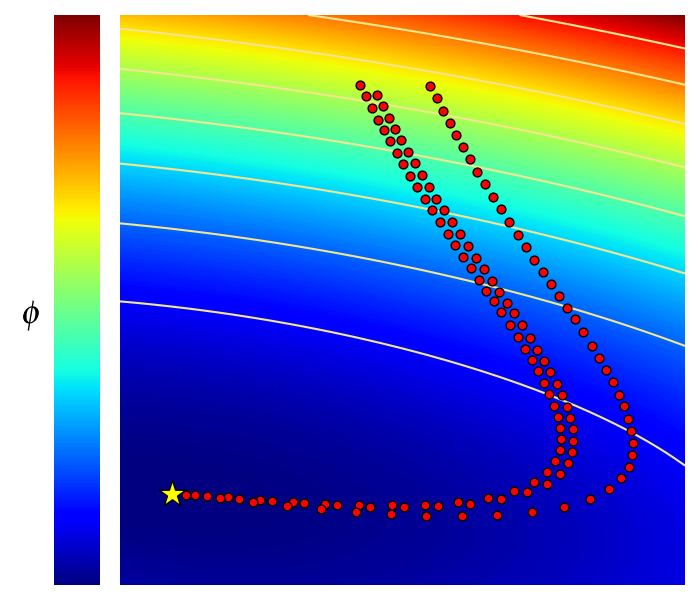

In [9]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_potential_second.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field & Streamlines

In [12]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
# embedding.local_deformation = phi


field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

# x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.01, samples=3).to(device).requires_grad_(True)
x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.1, lb=0.01, samples=5).to(device).requires_grad_(True)
v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=6.5, dt=0.01).cpu().detach().numpy()

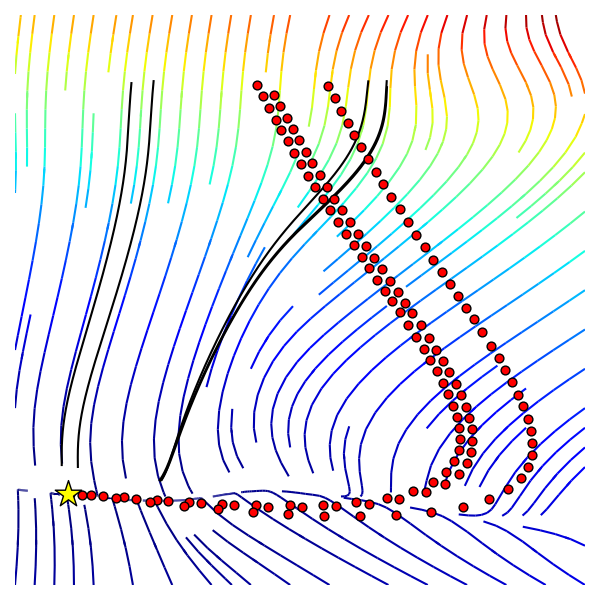

In [13]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="8%", pad=0.2)
# cax.yaxis.set_label_position("right")
# norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
# colors = plt.cm.jet(norm(potential))
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, cax=cax)
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(size=0)
# cbar.set_ticks([])
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_field_second.png', format='png', dpi=300, bbox_inches="tight")

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)

ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(r'$q_1$', fontsize=24)
ax.set_ylabel(r'$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_streamlines_second.png', format='png', dpi=300, bbox_inches="tight")

In [15]:
streamlines.shape

(650, 5, 4)

### Embedding

In [ ]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

steps = 20
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))

im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
ax.scatter(train_embedding[::steps, 0], train_embedding[::steps, 1], train_embedding[::steps, 2], s=20, edgecolors='k', c='red', zorder=10)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=30, azim=18)  # Adjust the elevation (up/down) and azimuth (left/right) an

# # Add colorbar without ticks and labels
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

# # Shrink colorbar to dimensions of the plot
# cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_embedding_second.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [ ]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)
evals /= torch.tensor([100,10000]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_detmetric_second.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [ ]:
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_evals/= torch.tensor([100,100]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_metric_second.png', format='png', dpi=300, bbox_inches="tight")

### Christoffel Symbols Ellispses on Streamlines

In [ ]:
christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_evals/= torch.tensor([20,0.000001]).to(device)

christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
        
# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_christoffel_second.png', format='png', dpi=300, bbox_inches="tight")